Example notebook to showcase the use of measure_eccentricity().   
Please do not commit your local changes.

NOTE: To work with EOB or NR data, you need the data first. Ask Arif where to get it.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import glob

import sys
sys.path.append("../")

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


### Currently implemented methods

Let's start by seeing which methods are currently implemented

In [2]:
available_methods = list(get_available_methods().keys())
print (available_methods)

['Amplitude', 'Frequency', 'ResidualAmplitude', 'ResidualFrequency', 'FrequencyFits']


In the following, we will use these different methods and show what the measured eccentricity looks like. The wrapper function, measure_eccentricity, allows you to easily switch between methods.

In [3]:
# Read the documentation
help(measure_eccentricity)

Help on function measure_eccentricity in module measureEccentricity.measureEccentricity:

measure_eccentricity(tref_in=None, fref_in=None, dataDict=None, method='Amplitude', return_ecc_method=False, spline_kwargs=None, extra_kwargs=None)
    Measure eccentricity and mean anomaly at reference time.
    
    parameters:
    ----------
    tref_in:
        Input reference time at which to measure eccentricity and mean anomaly.
        Can be a single float or an array. NOTE: eccentricity/mean_ano are
        returned on a different time array tref_out, described below.
    
    fref_in:
        Input reference frequency at which to measure the eccentricity and
        mean anomaly. It can be a single float or an array.
        NOTE: eccentricity/mean anomaly are returned on a different freq
        array fref_out, described below.
    
        Given an fref_in, we find the corresponding tref_in such that,
        omega22_average(tref_in) = 2 * pi * fref_in.
        Here, omega22_average(t

### Loading waveform data

Let's now get some waveform data in the required format, using the handy load_waveform function.

Waveform data for measure_eccentricity() are to be provided as a dictionary of different variables. In most cases, the required ones would be the time array and the dictionary of different modes. load_waveform function returns such a dictionary that could be directly used in the measure_eccentricity wrapper function.

In [4]:
help(load_waveform)

Help on function load_waveform in module measureEccentricity.load_data:

load_waveform(catalog='LAL', **kwargs)
    Load waveform from lvcnr file or LAL.
    
    parameters:
    ----------
    catalog:
          Waveform type. could be one of 'LAL', 'LVCNR', EOB
    
    kwargs:
         Kwargs to be passed to the waveform loading functions.



Here is an example of how to load a LAL waveform

In [5]:
# Let's try a PN eccentric model
# We use the keyword "include_zero_ecc" as we want to use the residual amplitude 
# method that needs data for the zero eccentricity counterpart as well
waveform_keywords = {"approximant": "EccentricTD",
                     "q": 1.0,
                     "chi1": [0.0, 0.0, 0.0],
                     "chi2": [0.0, 0.0, 0.0],
                     "deltaTOverM": 0.1,
                     "Momega0": 0.01,
                     "ecc": 0.1,
                     "mean_ano": 0,
                     "phi_ref": 0,
                     "inclination": 0,
                     "include_zero_ecc": True}
dataDictPN = load_waveform(catalog="LAL", **waveform_keywords)

We can use the data and see how the amplitude looks

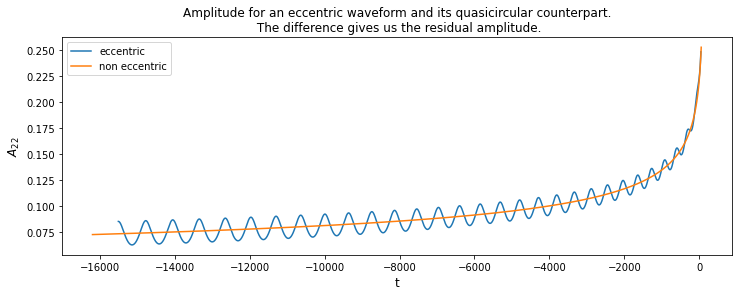

In [6]:
plt.figure(0, figsize=(12, 4))
plt.plot(dataDictPN["t"], np.abs(dataDictPN["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDictPN["t_zeroecc"], np.abs(dataDictPN["hlm_zeroecc"][(2, 2)]), label="non eccentric")
plt.xlabel('t', fontsize=12)
plt.ylabel('$A_{22}$', fontsize=12)
plt.title('Amplitude for an eccentric waveform and its quasicircular counterpart.\n '
          'The difference gives us the residual amplitude.')
plt.legend();

### Measure eccentricity at a given tref

Now that we have our dataDict ready, let's see how to use it in the measure_eccentricity wrapper function. Below we show how to get the eccentricity and mean anomaly at a given reference time.

In [7]:
# Use measure_eccentricity with your favorite method to 
# compute ecc and mean_ano at a given tref.
# The reason for having a separate tref_out is explained
# in the documentation, as well as below.
tref = -12000
tref_out, ecc, mean_ano = measure_eccentricity(tref_in=tref, dataDict=dataDictPN, method="Amplitude")
print (f"ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref_out}")

ecc=0.104 and mean_ano=5.951 at tref=-12000


We can try all the methods that are currently implemented

In [8]:
tref = -12000
for method in get_available_methods():
    tref_out, ecc, mean_ano = measure_eccentricity(tref_in=tref, dataDict=dataDictPN, method="Amplitude")
    print (f"method={method}: ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref_out}")

method=Amplitude: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=Frequency: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=ResidualAmplitude: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=ResidualFrequency: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=FrequencyFits: ecc=0.104 and mean_ano=5.951 at tref=-12000


### Measure eccentricity and mean anamoly at an array of reference times

Instead of measuring the eccentricity and mean anomaly at a single reference time, we might be interested in seeing how the eccentricity and mean anomaly vary with time.

For this, we simply pass the reference time array where we want to measure the eccentricity and the mean anomaly. We call this time array $t^\text{ref}_\text{in}$. The `measure_eccentricity` function then returns the measured values of eccentricity and mean anomaly and the time array $t^\text{ref}_\text{out}$ where these values are measured.

Note that $t^\text{ref}_\text{out}$ is generally **NOT** the same as $t^\text{ref}_\text{in}$. It would depend on few factors.
- $t^\text{ref}_\text{out}$ is basically $t^\text{ref}_\text{in}[t^\text{ref}_\text{in} \geq t_\text{min} \text{ and } t^\text{ref}_\text{in} < t_\text{max}]$ where $t_\text{min} = max(t_\text{peaks}[0], t_\text{troughs}[0])$ and $t_\text{max} = min(t_\text{peaks}[-1], t_\text{troughs}[-1])$. This is necessary because eccentricity is computed using interpolants of $\omega_{\text{peaks}}$ and $\omega_{\text{troughs}}$. The above cutoffs ensure that we are not extrapolating in $\omega_{\text{peaks}}$/$\omega_{\text{troughs}}$.
- It is observed that if the $\omega_{\text{peaks}}$/$\omega_{\text{troughs}}$ interpolators use the waveform data near the merger, the interpolants show some unphysical features like non-monotonicit eccentricity (see example below). To avoid this, one can exclude some of the data near the merger using the `num_orbits_to_exclude_before_merger` option. By default it is set to 1.

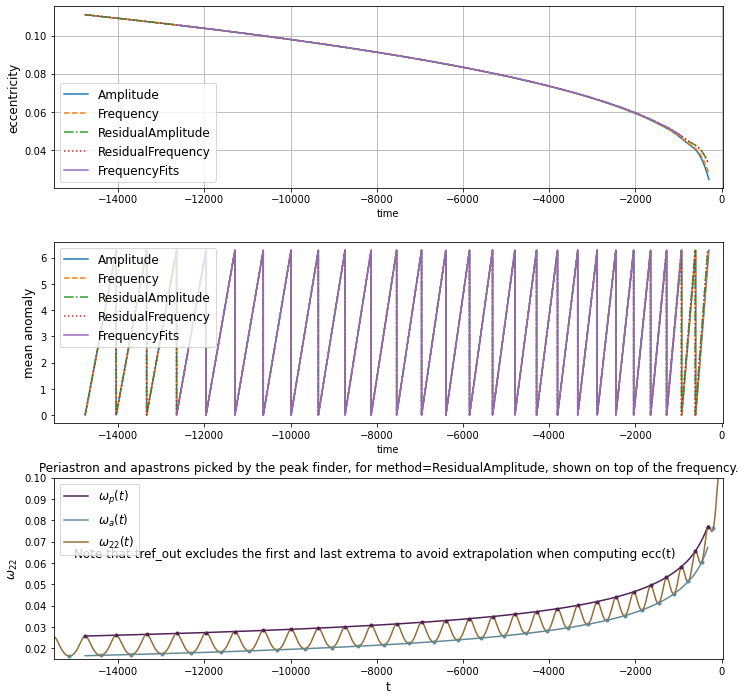

In [16]:
# refernce times at which to (attempt to) measure eccentricity and mean anomaly
tref_vec = dataDictPN["t"]

fig, axarr = plt.subplots(nrows=3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
lstyles = ["-", "--", "-.", ":", "-"]
colors = ["C0", "C1", "C2", "C3", "C4"]

for idx, method in enumerate(available_methods):
    # We use return_ecc_method=True so that it returns the eccMethod object that is 
    # used to measure the eccentricity and mean anomaly in measure_eccentricity. 
    # We can use this object to access almost all the necessary data that goes into 
    # the eccentricity measurement.
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDictPN, method=method, 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})
    # tref_out may not have the same initial value for all methods. This depends
    # on whether the extrema at the first time index gets picked up or not.
    # There is an extrema at the first time index here because the PN model 
    # we are considering only works for initial mean_ano=0.
    eccMethod.plot_measured_ecc(fig, axarr[0], **{"c": colors[idx], "label": method, "ls": lstyles[idx]})
    eccMethod.plot_mean_ano(fig, axarr[1], **{"c": colors[idx], "label": method, "ls": lstyles[idx]})
    
    if method == "ResidualAmplitude":
        # Plot omega(t) and peaks/troughs only for one case
        eccMethod.plot_extrema_in_omega22(fig, axarr[2])
        axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
                            f'for method={method}, shown on top of the frequency.', fontsize=12);
        axarr[2].text(0.03, 0.56, "Note that tref_out excludes the first and last extrema to avoid extrapolation when computing ecc(t)", transform=axarr[2].transAxes, fontsize=12)

axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].set_xlabel("t", fontsize=12)

axarr[0].set_xlim(min(tref_vec), max(tref_vec))
axarr[1].set_xlim(min(tref_vec), max(tref_vec))
axarr[2].set_xlim(min(tref_vec), max(tref_vec))

axarr[1].grid()
axarr[2].grid()

axarr[2].set_ylim(0.015, 0.1)

axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)
axarr[2].legend(fontsize=12, loc='best');

### Working with EOB data

See top of the notebook for how to get the EOB and NR data.   
Let's now see how to use an EOB waveform (Toni's model).

In [18]:
# Pick an EOB waveform from among the available ones, and load it
EOB_file = f"../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.2294236506_Momega00.010.h5"
EOB_file_zero_ecc = f"../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.0000000000_Momega00.002.h5"

eob_kwargs = {"filepath": EOB_file,
              "filepath_zero_ecc": EOB_file_zero_ecc,
              "include_zero_ecc": True} 
dataDictEOB = load_waveform("EOB", **eob_kwargs)

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinitionUsingAmplitude.py:79: PeakPropertyWarning: some peaks have a width of 0
  return find_peaks(
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


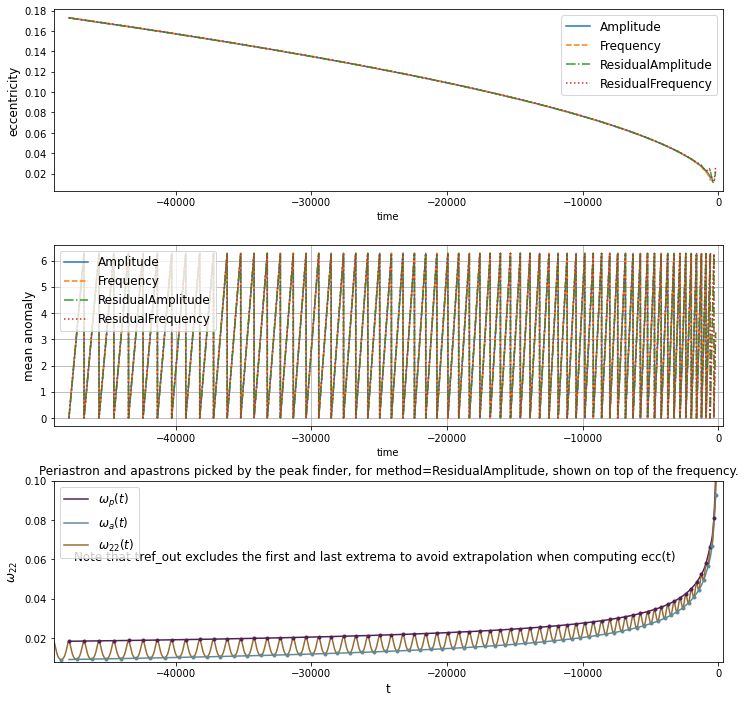

In [22]:
# refernce times at which to (attempt to) measure eccentricity and mean anomaly
tref_vec = dataDictEOB["t"]

fig, axarr = plt.subplots(nrows=3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
lstyles = ["-", "--", "-.", ":", "-"]
colors = ["C0", "C1", "C2", "C3", "C4"]

# FrequencyFits does not work now so not using it
for idx, method in enumerate(available_methods[:-1]):
    # We use return_ecc_method=True so that it returns the eccMethod object that is 
    # used to measure the eccentricity and mean anomaly in measure_eccentricity. 
    # We can use this object to access almost all the necessary data that goes into 
    # the eccentricity measurement.
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDictEOB, method=method, 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})
    # tref_out may not have the same initial value for all methods. This depends
    # on whether the extrema at the first time index gets picked up or not.
    # There is an extrema at the first time index here because the PN model 
    # we are considering only works for initial mean_ano=0.
    eccMethod.plot_measured_ecc(fig, axarr[0], **{"c": colors[idx], "label": method, "ls": lstyles[idx]})
    eccMethod.plot_mean_ano(fig, axarr[1], **{"c": colors[idx], "label": method, "ls": lstyles[idx]})
    
    if method == "ResidualAmplitude":
        # Plot omega(t) and peaks/troughs only for one case
        eccMethod.plot_extrema_in_omega22(fig, axarr[2])
        axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
                            f'for method={method}, shown on top of the frequency.', fontsize=12);
        axarr[2].text(0.03, 0.56, "Note that tref_out excludes the first and last extrema to avoid extrapolation when computing ecc(t)", transform=axarr[2].transAxes, fontsize=12)

axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].set_xlabel("t", fontsize=12)

axarr[0].set_xlim(min(tref_vec), max(tref_vec))
axarr[1].set_xlim(min(tref_vec), max(tref_vec))
axarr[2].set_xlim(min(tref_vec), max(tref_vec))

axarr[1].grid()
axarr[2].grid()

axarr[2].set_ylim(0.008, 0.1)

axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)
axarr[2].legend(fontsize=12, loc='best');

### Working with NR data

For some reason, you need to setup lalsuite-extra (https://git.ligo.org/lscsoft/lalsuite-extra) and point your `LAL_DATA_PATH` to `lalsuite-extra/data/lalsimulation/`. In particular, you need to have the file called `SEOBNRv4ROM_v2.0.hdf5`. It is silly that we need EOB ROM data to load NR data, but this will have to be fixed in lalsuite.

#### SXS waveforms
Now let's look at how one can use an SXS waveform.

In [23]:
# Pick an NR waveform from among the available ones, and load it
SXS_file = f'../data/ecc_waveforms/Non-Precessing/SXS/BBH_SHK_q4_e035_D26_Res3.h5'
sxs_kwargs = {"filepath": SXS_file, 
              "include_zero_ecc": True}   # For NR, we use PhenomT for the zero ecc waveform
dataDictSXS = load_waveform("LVCNR", **sxs_kwargs)

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


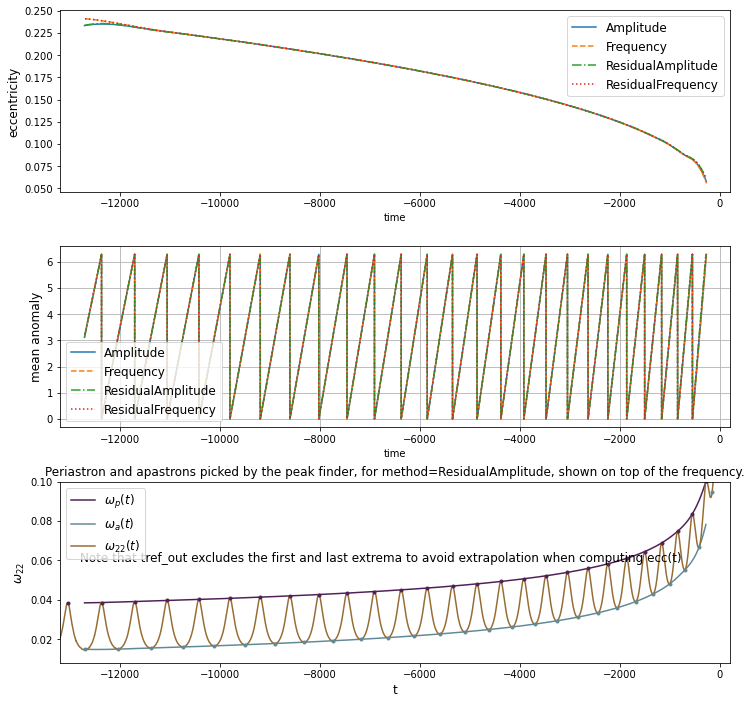

In [28]:
tref_vec = dataDictSXS["t"]

fig, axarr = plt.subplots(nrows=3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
lstyles = ["-", "--", "-.", ":", "-"]
colors = ["C0", "C1", "C2", "C3", "C4"]

# FrequencyFits does not work now so not using it
for idx, method in enumerate(available_methods[:-1]):
    # We use return_ecc_method=True so that it returns the eccMethod object that is 
    # used to measure the eccentricity and mean anomaly in measure_eccentricity. 
    # We can use this object to access almost all the necessary data that goes into 
    # the eccentricity measurement.
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDictSXS, method=method, 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})
    # tref_out may not have the same initial value for all methods. This depends
    # on whether the extrema at the first time index gets picked up or not.
    # There is an extrema at the first time index here because the PN model 
    # we are considering only works for initial mean_ano=0.
    eccMethod.plot_measured_ecc(fig, axarr[0], **{"c": colors[idx], "label": method, "ls": lstyles[idx]})
    eccMethod.plot_mean_ano(fig, axarr[1], **{"c": colors[idx], "label": method, "ls": lstyles[idx]})
    
    if method == "ResidualAmplitude":
        # Plot omega(t) and peaks/troughs only for one case
        eccMethod.plot_extrema_in_omega22(fig, axarr[2])
        axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
                            f'for method={method}, shown on top of the frequency.', fontsize=12);
        axarr[2].text(0.03, 0.56, "Note that tref_out excludes the first and last extrema to avoid extrapolation when computing ecc(t)", transform=axarr[2].transAxes, fontsize=12)

axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].set_xlabel("t", fontsize=12)

axarr[0].set_xlim(min(tref_vec), max(tref_vec))
axarr[1].set_xlim(min(tref_vec), max(tref_vec))
axarr[2].set_xlim(min(tref_vec), max(tref_vec))

axarr[1].grid()
axarr[2].grid()

axarr[2].set_ylim(0.008, 0.1)

axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)
axarr[2].legend(fontsize=12, loc='best');

Below we plot differenct quantities to asses how well our eccentricity measurment method is working. This could be seen as a diagnostic tool to check an implemented method.

We plot the following quantities
- The eccentricity vs $t^\text{ref}_\text{out}$
- $de/dt$ vs time, this is to test the monotonicity of eccentricity as a function of time
- mean anomaly vs $t^\text{ref}_\text{out}$
- $\omega_{22}$ vs $t^\text{ref}_\text{out}$ with the peaks and troughs shown. This would show if the method is missing any peaks/troughs or selecting one which is not a peak/trough and finally
- $\Delta\phi^{i}_\text{orb}/\Delta\phi^{i-1}_\text{orb}$, where $\Delta\phi^{i}_\text{orb}$ is the change in orbital phase from the previous extrema to the ith extrema. This helps look for missing extrema, as there will be a drastic (roughly factor of 2) change in $\Delta\phi^{i}_\text{orb}$ if there is a missing extrema, and the ratio will go from ~1 to ~2.

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


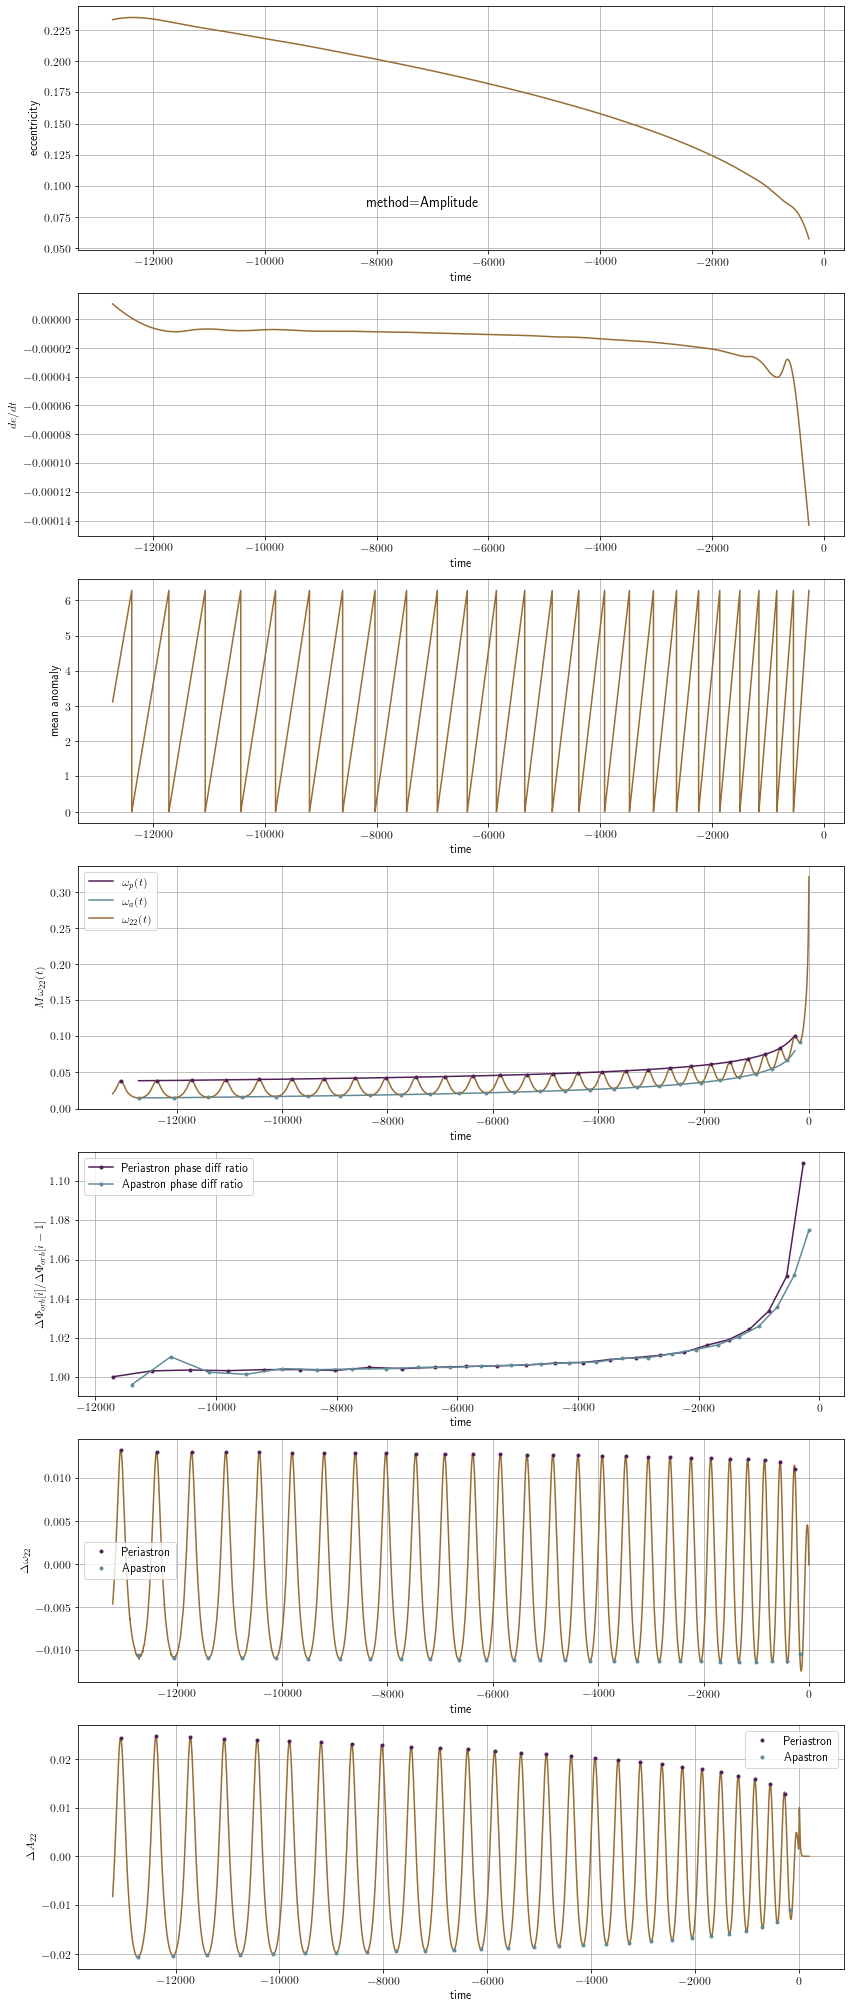

In [31]:
method = "Amplitude"
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDictSXS, method=method, 
                                                                  return_ecc_method=True)
eccMethod.make_diagnostic_plots()

#axarr[0].set_xlabel("t", fontsize=12)
#axarr[0].set_ylabel("eccentricity", fontsize=12)
#axarr[0].grid()

#axarr[1].set_xlabel("t", fontsize=12)
#axarr[1].set_ylabel("decc/dt", fontsize=12)
#axarr[1].set_title("We expect decc/dt to be always negative", fontsize=12, y=0.35);
#axarr[1].grid()

#axarr[2].set_xlabel("t", fontsize=12)
#axarr[2].set_ylabel("mean anomaly", fontsize=12)
#axarr[2].grid()

#axarr[3].set_ylim(0.01, 0.12)
#axarr[3].set_xlim(min(tref_vec),)
#axarr[3].set_xlabel("t", fontsize=12)
#axarr[3].set_ylabel("$\omega_{22}$", fontsize=12)
#axarr[3].grid()
#axarr[3].legend(fontsize=12)
#axarr[3].set_title('Periastron and apastrons picked by the peak finder, '
#          'shown on top of the frequency.', fontsize=12);

#tpeaks = eccMethod.t[eccMethod.peaks_location[1:]]
#axarr[4].set_xlabel("t", fontsize=12)
#axarr[4].set_ylabel("$\Delta \Phi_{orb}[i] / \Delta \Phi_{orb}[i-1]$")
#axarr[4].grid()
#axarr[4].legend()

plt.suptitle(f"method={method}", y=0.9, fontsize=14);

### setting `num_orbits_to_exclude_before_merger` to 0

By default it is set to 1. Which means that the data only upto 1 orbits before the merger is used when finding the peaks and troughs. However if we set it to 0, it will use data all the way up to the merger and hence it could mistake the merger as a periastron. Let's see an example.

In [32]:
method = "Amplitude"
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDictSXS, method=method, 
                                                                  return_ecc_method=True,
                                                                  extra_kwargs={"num_orbits_to_exclude_before_merger": 0})

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:378: UserWarning: At least a pair of peaks are too far. Maximum orbital phase diff is 16.74330564859892. Times of occurances are [0.00245741]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


We immediately notice two warnings:
- First one says that at least a pair of peaks are too far, i.e., the phase diff at some peak is atleast 1.5 times the phase diff at the previous peak. Here we see that actual the phase difference between two peaks is about 17 ~ 5 pi. This suggests that either a peak is being missed by the method, or something else like bad interpolation is causing a big jump in the phase diff.
- Last one says that ecc is non monotonic, this is because now the extrema interpolation uses a peak close to the merger and hence the interpolation show weird feature.

Lets see how these are reflected in the diagnostic plots

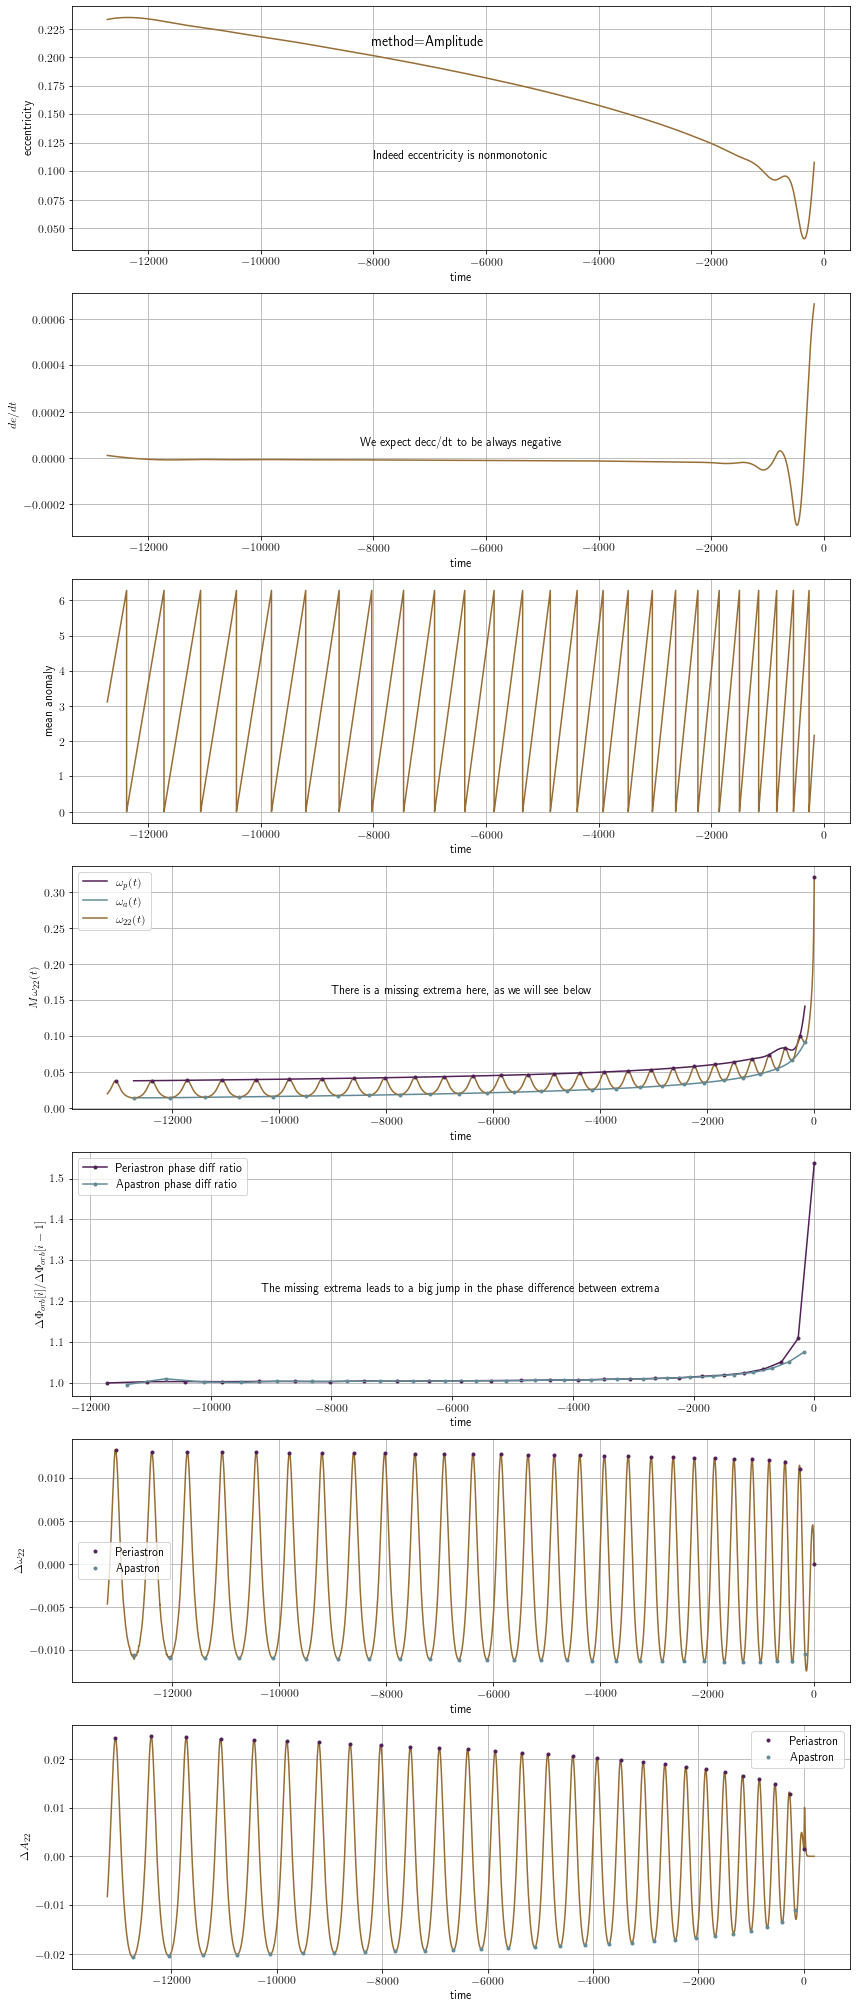

In [35]:
fig, axarr = eccMethod.make_diagnostic_plots()

axarr[0].set_title("Indeed eccentricity is nonmonotonic", fontsize=12, y=0.35);
axarr[1].set_title("We expect decc/dt to be always negative", fontsize=12, y=0.35);
axarr[3].set_title("Notice how the interpolant is becoming weird near the merger", fontsize=12, y=0.45);
axarr[3].set_title("There is a missing extrema here, as we will see below", fontsize=12, y=0.45);
axarr[4].set_title("The missing extrema leads to a big jump in the phase difference between extrema", fontsize=12, y=0.4);
plt.suptitle(f"method={method}", fontsize=14);

Lets repeat this with `ResidualAmplitude` Method

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


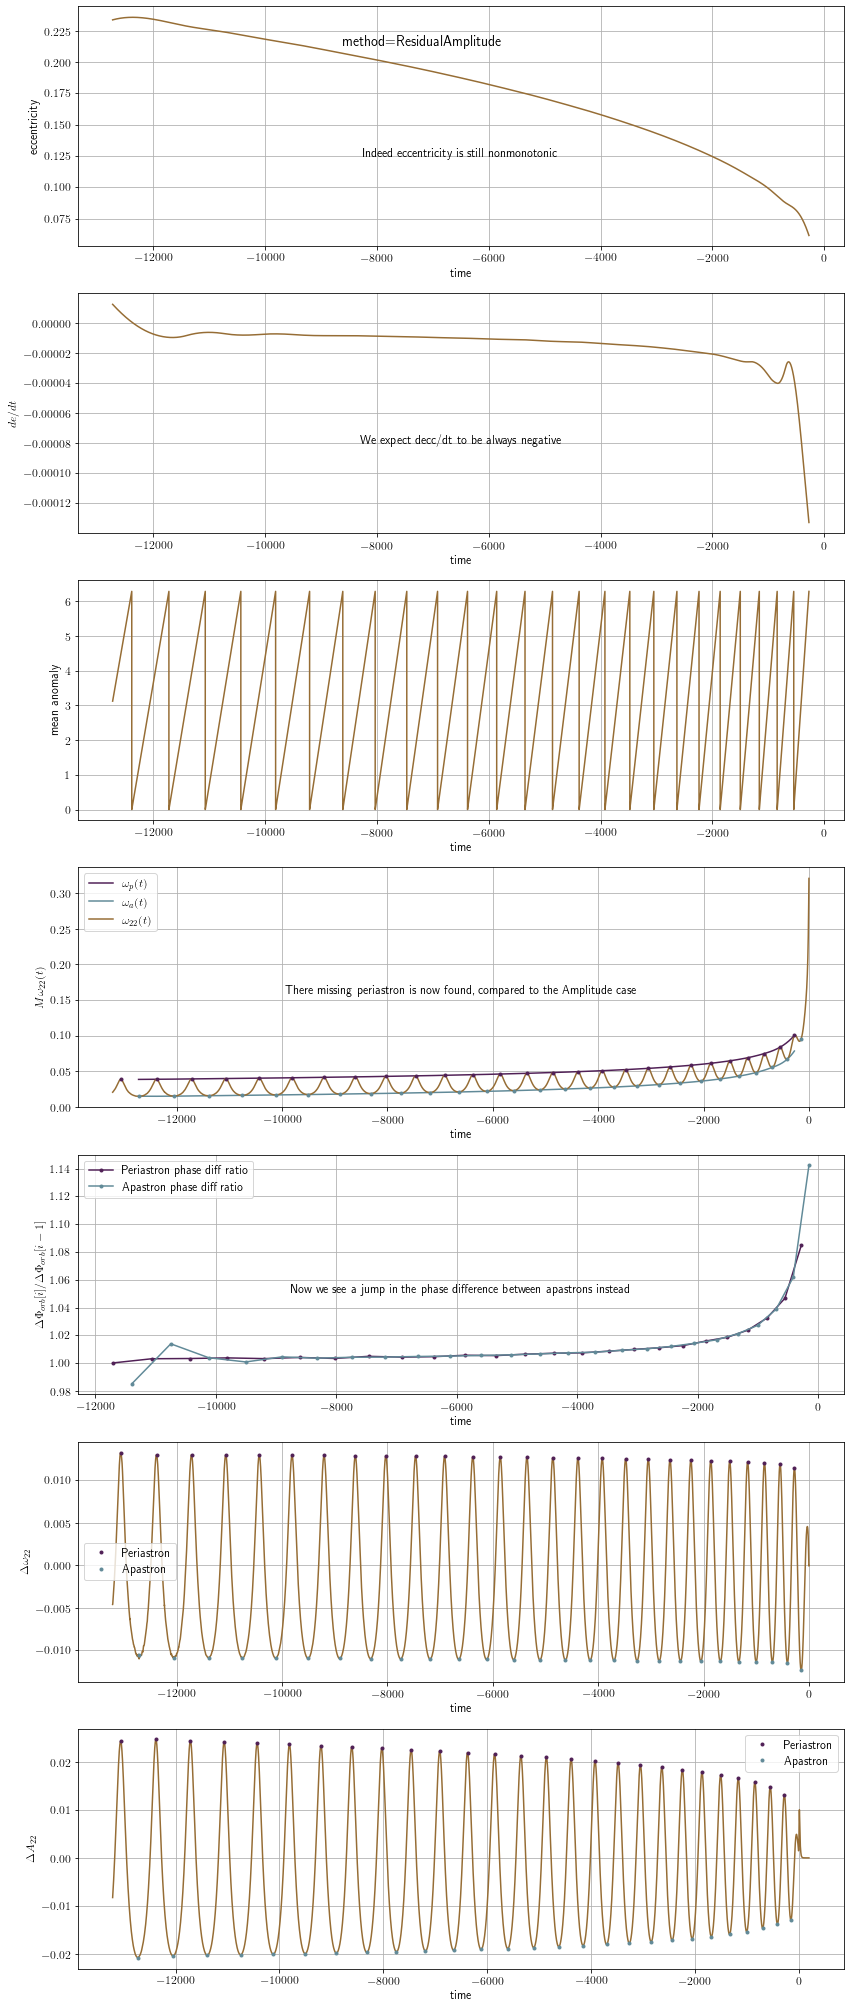

In [36]:
method = "ResidualAmplitude"
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDictSXS, method=method, 
                                                                  return_ecc_method=True,
                                                                  extra_kwargs={"num_orbits_to_exclude_before_merger": 0})
fig, axarr = eccMethod.make_diagnostic_plots()
axarr[0].set_title("Indeed eccentricity is still nonmonotonic", fontsize=12, y=0.35);
axarr[1].set_title("We expect decc/dt to be always negative", fontsize=12, y=0.35);
axarr[3].set_title("The periastron interpolant is better, but now the apastron interpolant is weird near the merger", fontsize=12, y=0.45);
axarr[3].set_title("There missing periastron is now found, compared to the Amplitude case", fontsize=12, y=0.45);
axarr[4].set_title("Now we see a jump in the phase difference between apastrons instead", fontsize=12, y=0.4);
plt.suptitle(f"method={method}", fontsize=14);